# Experiment to use neural network to capture interation effects in logistic price-response model

## Preliminaries

In [923]:
import numpy as np
import pandas as pd
import random
from numpy.random import default_rng
import math
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [577]:
%matplotlib inline

# Toy example to check can generate data and recover parameters correctly

## Generate dummy data to work with

In [878]:
data_params = {
    'intercept_A':1,
    'intercept_B':0,
    'price_slope_A':-1,
    'price_slope_B':-2,
    'pct_A':0.5,
    'noise_sd':0.2,
    'num_rows':10000,
    'price_min':1,
    'price_max':100
}

In [879]:
rng = default_rng()
is_A = rng.binomial(1, data_params['pct_A'], data_params['num_rows'])
is_B = 1 - is_A
real_price = rng.uniform(data_params['price_min'], data_params['price_max'], data_params['num_rows'])
price =  ( real_price - np.mean(real_price) ) / np.std(real_price)
price_A = is_A * price
price_B = is_B * price
noise = rng.normal(0, data_params['noise_sd'], data_params['num_rows'])
xB = is_A*data_params['intercept_A'] + is_B*data_params['intercept_B'] \
    + price_A*data_params['price_slope_A'] + price_B*data_params['price_slope_B'] + noise
probs = 1 / ( 1 + np.exp(-1*xB))
response = rng.binomial(1, probs)

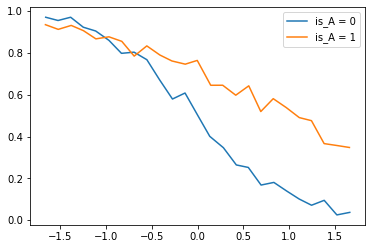

In [880]:
g = pd.DataFrame({'price':price.reshape(-1),'response':response, 'is_A':is_A}) 
g['price_cat'] = pd.cut(price.reshape(-1), 25)
gg = g.groupby(['price_cat','is_A']).mean().reset_index()
for i in gg['is_A'].unique():
    plt.plot('price','response', data=gg[gg['is_A']==i], label='is_A = ' + str(i))
plt.legend()    
plt.show()

In [881]:
a = np.column_stack((is_A, is_B, price, price_A, price_B, noise, xB, response))

In [882]:
df = pd.DataFrame(a, columns=['is_A', 'is_B', 'price', 'price_A', 'price_B', 'noise', 'xB', 'response'])

In [883]:
df.sample(3)

,is_A,is_B,price,price_A,price_B,noise,xB,response
7950,0.0,1.0,1.616534,0.0,1.616534,-0.380217,-3.613284,0.0
9624,0.0,1.0,-1.000332,-0.0,-1.000332,-0.268087,1.732577,1.0
7461,0.0,1.0,-1.302478,-0.0,-1.302478,0.272186,2.877141,1.0


## Prep data for modelling

### Test / train split

In [884]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('response',axis=1), df['response'], test_size=0.30, random_state=101)

### Create generator to yield batches for NN training

In [885]:
def get_batch(X, X_cols, y, batch_size=56):
    X = X[X_cols]
    l = len(X)
    i = 0
    while i + 1 < l:
        first = i
        last = min(first+batch_size, l)
        yield torch.tensor(X[first:last].values.astype(np.float32)), torch.tensor(y[first:last].values.astype(np.float32))
        i = last

## Define NN model for predicting response

In [886]:
class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2, bias=False)
        #self.fc2 = nn.Linear(2, 2)
        
    def forward(self, x):
        
        # assume price is in the last column of x...only use non-price columns in NN
        price = x[:,-1]
        x = x[:,:-1]
        
        # pass x through fully connected layers, no activation for now....
        x = self.fc1(x)
        #x = self.fc2(x)
        
        # calculate
        xB = x[:,0] + x[:,1]*price
        #response = 1 / ( 1 + torch.exp(-xB))
        
        return xB

In [894]:
model = Predictor()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)
epochs = 20

In [895]:
for e in range(epochs):
    train_batch = get_batch(X_train,['is_A', 'is_B', 'price'], y_train, 32)
    running_loss = 0
    batch_num = 0
    for X, y in train_batch:
        
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        batch_num += 1

    print(f"Training loss: {running_loss/batch_num}")

Training loss: 0.6477025661566486
Training loss: 0.5121901420425606
Training loss: 0.4938194393839466
Training loss: 0.48939494319158056
Training loss: 0.48799826143539116
Training loss: 0.48749396477115753
Training loss: 0.4872971469681013
Training loss: 0.48721639233637076
Training loss: 0.48718209979740995
Training loss: 0.48716717373290563
Training loss: 0.48716054033471023
Training loss: 0.4871575394177546
Training loss: 0.48715615517472566
Training loss: 0.48715550061230245
Training loss: 0.48715518394561663
Training loss: 0.4871550183317977
Training loss: 0.487154940083691
Training loss: 0.4871548965369185
Training loss: 0.48715486755109816
Training loss: 0.4871548482272179


In [896]:
with torch.no_grad():
    logit_pred = model(torch.tensor(X_test[['is_A', 'is_B', 'price']].values.astype(np.float32)))
pred = 1 / ( 1 + torch.exp(-logit_pred))

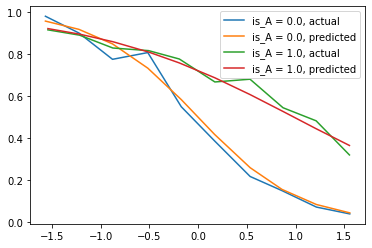

In [897]:
g = pd.DataFrame({'price':X_test.price,'actual_response':y_test, 'is_A':X_test.is_A, 'predicted_response':pred})
g['price_cat'] = pd.cut(X_test.price, 10)
gg = g.groupby(['price_cat','is_A']).mean().reset_index()
for i in gg['is_A'].unique():
    plt.plot('price','actual_response', data=gg[gg['is_A']==i], label='is_A = ' + str(i) + ', actual')
    plt.plot('price', 'predicted_response', data=gg[gg['is_A']==i], label='is_A = ' + str(i) + ', predicted')
plt.legend()    
plt.show()

In [898]:
print(model.fc1.weight)
print('Correct values used to generate raw data:')
print(np.array([[data_params['intercept_A'], data_params['intercept_B']],
      [data_params['price_slope_A'], data_params['price_slope_B']]]))

Parameter containing:
tensor([[ 0.9524, -0.0020],
        [-0.9703, -1.9722]], requires_grad=True)
Correct values used to generate raw data:
[[ 1  0]
 [-1 -2]]


# More complex example

## Generate dummy data to work with

In [1140]:
data_params = {
    'num_features': 10,
    'features_mean':0,
    'features_std':1,
    'main_effect_mean':0,
    'main_effect_std':1,
    'price_slope':-1,
    'price_effect_max':-0.1,
    'price_effect_min':-2,
    'num_interactions': 5,
    'num_price_interactions':5,
    'interaction_effect_mean':0,
    'interaction_effect_std':1,   
    'price_interaction_effect_max':-0.1,
    'price_interaction_effect_min':-0.5,    
 
    'noise_sd':0.1,
    'num_rows':10000,
    'price_min':1,
    'price_max':100
}

In [1141]:
rng = default_rng()

x_1 = rng.normal(data_params['features_mean'], data_params['features_std'], (data_params['num_rows'], data_params['num_features']))
B_1 = rng.normal(data_params['main_effect_mean'], data_params['main_effect_std'], data_params['num_features'])

real_price = rng.uniform(data_params['price_min'], data_params['price_max'], data_params['num_rows'])
price =  ( real_price - np.mean(real_price) ) / np.std(real_price)
price = price.reshape(-1,1)

B_price = np.array([data_params['price_slope']])

x_1p = x_1 * price
B_1p = rng.uniform(data_params['price_effect_min']/data_params['num_features'], data_params['price_effect_max']/data_params['num_features'], data_params['num_features'])

feature_pairs = []
for i in range(data_params['num_features']):
    for j in range(data_params['num_features']):
        if i != j:
            feature_pairs.append((i,j))

interactions = random.sample(feature_pairs, data_params['num_interactions'])
price_interactions = random.sample(feature_pairs, data_params['num_price_interactions'])

x_2 = np.empty(shape=(data_params['num_rows'], data_params['num_interactions']))
for i, pair in enumerate(interactions):
    x_2[:,i] = x_1[:,pair[0]] * x_1[:,pair[1]]
x_2p = x_2 * price

B_2 = rng.normal(data_params['interaction_effect_mean'], data_params['interaction_effect_std'], data_params['num_interactions'])
B_2p = rng.uniform(data_params['price_interaction_effect_min']/data_params['num_price_interactions'], data_params['price_interaction_effect_max']/data_params['num_price_interactions'], data_params['num_price_interactions'])

x = np.column_stack((x_1, price, x_1p, x_2, x_2p))
B = np.concatenate((B_1, B_price, B_1p, B_2, B_2p))
xB = np.dot(x, B)

noise = rng.normal(0, data_params['noise_sd'], data_params['num_rows'])

probs = 1 / ( 1 + np.exp(-1*(xB + noise)))
response = rng.binomial(1, probs)

alpha = np.dot( np.column_stack((x_1, x_2)), np.concatenate((B_1, B_2)) )
beta = (xB - alpha) / price.reshape(-1)

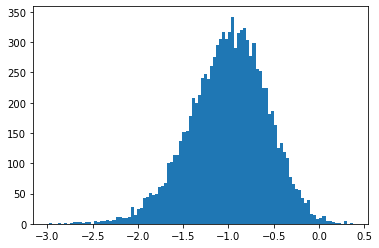

In [1142]:
_ = plt.hist(beta, bins=100)

In [1143]:
def grid_plot(alpha, beta, rows=8, columns=6):
    
    idx = random.sample(range(len(alpha)),rows*columns)
    price = np.arange(-2,2,0.1)
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15,10), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        logit = alpha[i] + price*beta[i]
        response = 1 / ( 1 + np.exp(-1*logit))
        ax.plot(price, response)

    plt.show()

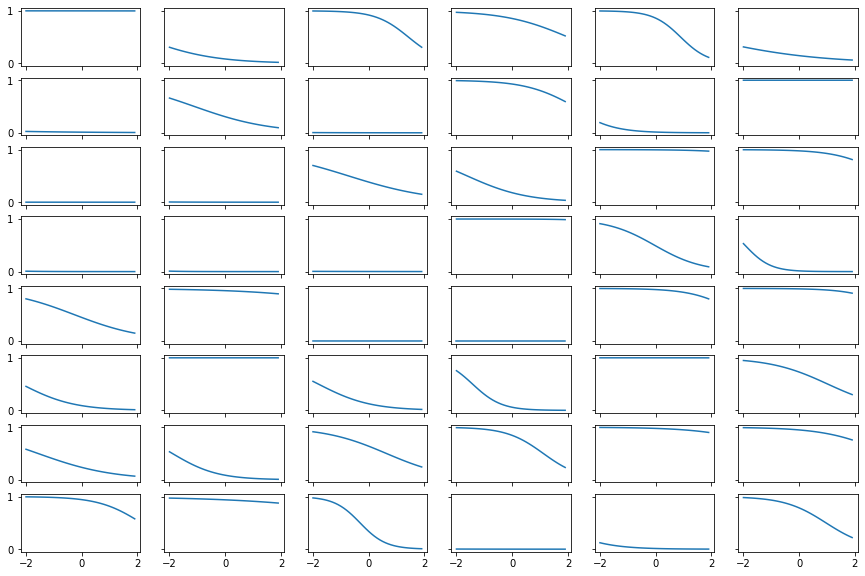

In [1144]:
grid_plot(alpha, beta)

In [1145]:
a = np.column_stack((x_1, price, x_1p, x_2, x_2p, alpha, beta, response))
b = a[beta<0]

In [1146]:
x_cols = [ "x_" + str(i+1) for i in range(data_params['num_features']) ]
xp_cols = [ "xp_" + str(i+1) for i in range(data_params['num_features']) ]
i_cols = [ "x_" + str(pair[0]+1) + "_" + str(pair[1]+1) for pair in interactions ]
ip_cols = [ i + "_p" for i in i_cols ]

In [1147]:
df = pd.DataFrame(b, columns=x_cols + ['price'] + xp_cols + i_cols + ip_cols + ['alpha', 'beta', 'response'])

In [1148]:
df.sample(3)

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_3_7,x_1_4,x_3_1_p,x_8_9_p,x_3_5_p,x_3_7_p,x_1_4_p,alpha,beta,response
283,0.135444,0.776218,-0.286615,-0.046929,-0.433478,0.147756,0.367043,0.407321,-1.054098,-0.424411,...,-0.105200,-0.006356,0.010908,0.120647,-0.034911,0.029561,0.001786,-2.542190,-0.806697,0.0
5493,-0.801545,-0.863438,-1.511664,0.529115,-0.188902,0.096238,0.224475,-0.297305,-0.607723,0.113796,...,-0.339331,-0.424109,-0.687496,-0.102517,-0.162024,0.192535,0.240638,-6.156165,-0.623168,0.0
254,0.070271,-0.001329,-0.115816,-2.519819,-1.607538,-0.459835,-0.545643,0.619140,-0.302636,-0.057880,...,0.063194,-0.177070,-0.004638,-0.106792,0.106110,0.036017,-0.100919,1.115026,-0.561226,1.0


## Prep data for modelling

### Test train split

In [1149]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('response',axis=1), df['response'], test_size=0.30, random_state=101)

### Generator to yield batches of data for NN training

In [1150]:
def get_batch(X, X_cols, y, batch_size=56):
    X = X[X_cols]
    l = len(X)
    i = 0
    while i + 1 < l:
        first = i
        last = min(first+batch_size, l)
        yield torch.tensor(X[first:last].values.astype(np.float32)), torch.tensor(y[first:last].values.astype(np.float32))
        i = last

## NN model to predict response

In [1151]:
class Predictor(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        fc1out_num_features = max(2, int(self.num_features/2))
        self.fc1 = nn.Linear(self.num_features, self.num_features)
        self.fc2 = nn.Linear(self.num_features, 2, bias=False)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        
        # assume price is in the last column of x...only use non-price columns in NN
        price = x[:,-1]
        x = x[:,:-1]
        
        # pass x through fully connected layers, no activation, dropout, normalisation etc. for now....
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        
        # calculate
        alpha = x[:,0] 
        beta = x[:,1]
        xB = alpha + beta*price
        #response = 1 / ( 1 + torch.exp(-xB))
        
        return xB, alpha, beta

In [1152]:
model = Predictor(data_params['num_features'])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)
epochs = 100

In [1153]:
for e in range(epochs):
    train_batch = get_batch(X_train,x_cols+['price'], y_train, 64)
    running_loss = 0
    batch_num = 0
    for X, y in train_batch:
        
        optimizer.zero_grad()
        logits, alpha, beta = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        batch_num += 1

    print(f"Training loss: {running_loss/batch_num}")

Training loss: 0.6934611469233801
Training loss: 0.5760068010299577
Training loss: 0.5079377881430704
Training loss: 0.4851164205358663
Training loss: 0.4779717091026656
Training loss: 0.47414586795579405
Training loss: 0.4707476764643958
Training loss: 0.4668999027221575
Training loss: 0.4621852740235285
Training loss: 0.4563378349903527
Training loss: 0.4491626724190668
Training loss: 0.44053498457331175
Training loss: 0.43046951840776915
Training loss: 0.4192257922723753
Training loss: 0.407355933014406
Training loss: 0.39559350921473374
Training loss: 0.3846110351588748
Training loss: 0.37483150669194143
Training loss: 0.3664035090339293
Training loss: 0.3592786877800565
Training loss: 0.3533033016351385
Training loss: 0.34828614956195203
Training loss: 0.3440387873748027
Training loss: 0.34039498059027784
Training loss: 0.3372170437093175
Training loss: 0.33439538539002794
Training loss: 0.331844974275029
Training loss: 0.32950098730555366
Training loss: 0.3273147038363535
Trainin

In [1154]:
with torch.no_grad():
    pred_logit, pred_alpha, pred_beta = model(torch.tensor(X_test[x_cols+['price']].values.astype(np.float32)))

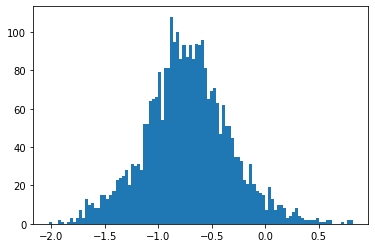

In [1155]:
_ = plt.hist(pred_beta.numpy(), bins=100)

In [1156]:
def grid_plot(pred_alpha, pred_beta, actual_alpha, actual_beta, rows=8, columns=6):
    
    idx = random.sample(range(len(pred_alpha)),rows*columns)
    price = np.arange(-2,2,0.1)
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15,10), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        pred_logit = pred_alpha[i] + price*pred_beta[i]
        pred_response = 1 / ( 1 + np.exp(-1*pred_logit))
        actual_logit = actual_alpha[i] + price*actual_beta[i]
        actual_response = 1 / ( 1 + np.exp(-1*actual_logit))        
        ax.plot(price, pred_response, price, actual_response)

    handles = plt.gca().get_lines()
    labels = ['pred','actual']
    fig.legend(handles, labels, loc='upper center')
    plt.show()

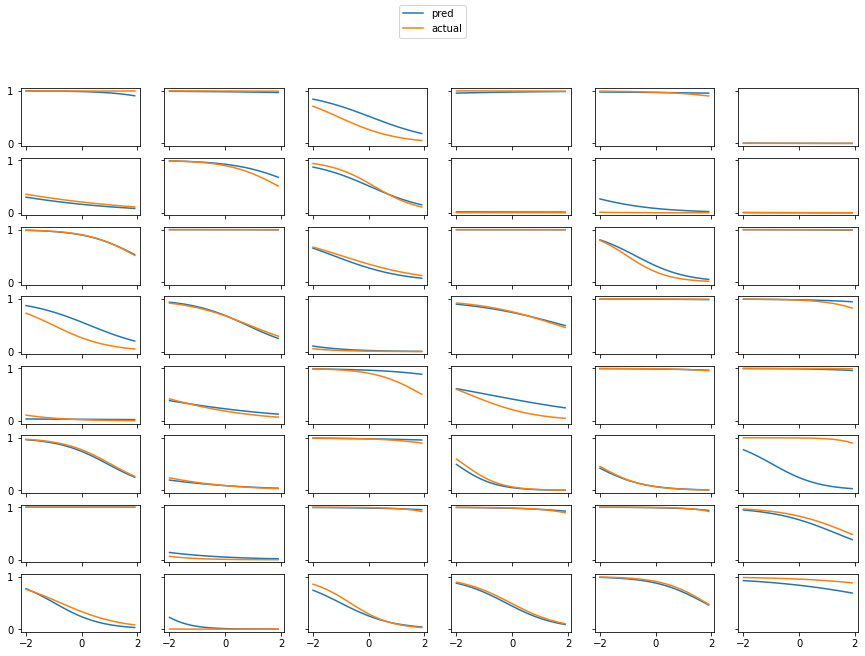

In [1157]:
grid_plot(pred_alpha.numpy(), pred_beta.numpy(), X_test['alpha'].to_numpy(), X_test['beta'].to_numpy())

## Assess model performance vs naive and 'perfect' logistic regression models

### A logistic regression model with the same structure as the logistic equation used to generate the data can accurately recover the parameter values used in that equation

In [1158]:
complete_reg = LogisticRegression()
complete_reg.fit(X_train[x_cols + ['price'] + xp_cols + i_cols + ip_cols], y_train)

LogisticRegression()

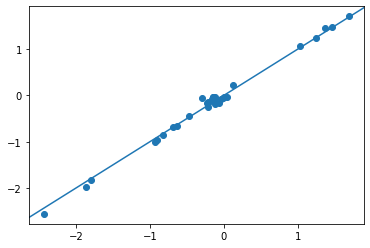

In [1159]:
est_B = complete_reg.coef_.reshape(-1) # parameter values estimated by complete model
actual_B = np.concatenate((B_1, B_price, B_1p, B_2, B_2p)) # parameter values used to generate data

plt.scatter(est_B, actual_B)
plt.axline([0, 0], [1, 1])

In [1165]:
complete_pred = complete_reg.predict_proba(X_test[x_cols + ['price'] + xp_cols + i_cols + ip_cols])[:,1]
complete_loss = log_loss(y_test, complete_pred)
print('The average loss on the test data for the "complete" logistic regression model is: ' + '{:.2f}'.format(complete_loss))

The average loss on the test data for the "complete" logistic regression model is: 0.26


### A naive logistic regression model with only main effects has a signifcantly higher loss

In [1166]:
simple_reg = LogisticRegression()
simple_reg.fit(X_train[x_cols+['price']], y_train)
simple_pred = simple_reg.predict_proba(X_test[x_cols+['price']])[:,1]
simple_loss = log_loss(y_test, simple_pred)
print('The average loss on the test data for the "naive" logistic regression model is: ' + '{:.2f}'.format(simple_loss))

The average loss on the test data for the "naive" logistic regression model is: 0.49


### The performace of the NN model can be benchmarked to these regression models

In [1167]:
nn_pred = 1 / (1 + np.exp(-1*pred_logit)) 
nn_loss = log_loss(y_test, nn_pred)
print('The average loss on the test data for the neural network model is: ' + '{:.2f}'.format(nn_loss))

The average loss on the test data for the neural network model is: 0.29


In [1168]:
NN_performance = ( nn_loss - simple_loss ) / ( complete_loss - simple_loss )
print('The NN model achieves ' + '{:.0%}'.format(NN_performance) + ' of the performance of the "complete" model')

The NN model achieves 86% of the performance of the "complete" model
